# **Predict the success of Bank Telemarketing**

# ***Overview***
The data is related with direct marketing campaigns of a banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

By leveraging machine learning techniques, we will analyze this rich dataset to predict the success of Bank Telemarketing.

# 1. Importing Required Libraries

In [1]:
# Visualizations
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Preprocessing and Cleaning
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import OrdinalEncoder,FunctionTransformer
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.feature_selection import RFE

#Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb

#Metrics
from sklearn.model_selection import cross_val_score,ShuffleSplit,KFold,GridSearchCV
from sklearn.model_selection import RandomizedSearchCV,learning_curve,StratifiedKFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,log_loss,make_scorer
from sklearn.metrics import ConfusionMatrixDisplay,f1_score,roc_curve,auc,silhouette_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
#

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


# Display and warning setting

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 2. Data loading

In [3]:
sample = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv')
train_data = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
test_data = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')

# 3. EDA(Exploratory Data Analysis)

* The shape of df_training dataset is 39211 rows(samples) and 16 columns(features = 15 + Target = 1)

**Features:**
* Numerical:
1. **last contact date**: last contact date
2. **age** (numeric)
3. **balance**: average yearly balance, in euros (numeric)
4. **duration**: last contact duration, in seconds (numeric)
5. **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)
6. **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
7. **previous**: number of contacts performed before this campaign and for this client (numeric)

* Categorical:
1. **job** : type of job
2. **marital** : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
3. **education** (categorical: "unknown","secondary","primary","tertiary")
4. **default**: has credit in default? (binary: "yes","no")
5. **housing**: has housing loan? (binary: "yes","no")
6. **loan**: has personal loan? (binary: "yes","no")
7. **contact**: contact communication type (categorical: "unknown","telephone","cellular")
8. **poutcome**: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

**Output variable (desired target)**:
1. **target**: has the client subscribed a term deposit? (binary: "yes","no")

# Basic Statistics

In [4]:
train_data.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


In [5]:
test_data.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,2009-11-21,36,management,single,tertiary,no,7,no,no,NaN,20,1,-1,0,NaN
1,2010-02-04,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,NaN
2,2010-07-28,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,NaN
3,2010-06-09,38,admin.,married,primary,no,1487,no,no,NaN,332,2,-1,0,NaN
4,2008-03-02,59,management,married,tertiary,no,315,no,no,cellular,591,1,176,2,failure


In [6]:
train_data.shape

(39211, 16)

In [7]:
test_data.shape

(10000, 15)

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  10000 non-null  object
 1   age                10000 non-null  int64 
 2   job                9941 non-null   object
 3   marital            10000 non-null  object
 4   education          9610 non-null   object
 5   default            10000 non-null  object
 6   balance            10000 non-null  int64 
 7   housing            10000 non-null  object
 8   loan               10000 non-null  object
 9   contact            7316 non-null   object
 10  duration           10000 non-null  int64 
 11  campaign           10000 non-null  int64 
 12  pdays              10000 non-null  int64 
 13  previous           10000 non-null  int64 
 14  poutcome           2492 non-null   object
dtypes: int64(6), object(9)
memory usage: 1.1+ MB


In [10]:
# Define Categorical & Numerical Variables 
cat_var = train_data.select_dtypes(include=['object']).columns.values
num_var = train_data.select_dtypes(include=['int64']).columns.values
features = train_data.drop("target", axis=1)
target = train_data["target"]

In [11]:
#----- Unique Values of Categorical Variables -----#
for column in train_data[cat_var]:
    print(f"{column} :")
    print(train_data[column].unique(), "\n")

last contact date :
['2009-04-17' '2009-10-11' '2010-11-20' ... '2009-07-05' '2008-02-25'
 '2010-04-12'] 

job :
['blue-collar' 'technician' 'admin.' 'entrepreneur' 'unemployed'
 'management' 'services' 'student' 'self-employed' 'retired' 'housemaid'
 nan] 

marital :
['married' 'single' 'divorced'] 

education :
['secondary' 'tertiary' 'primary' nan] 

default :
['no' 'yes'] 

housing :
['yes' 'no'] 

loan :
['no' 'yes'] 

contact :
['cellular' 'telephone' nan] 

poutcome :
['other' nan 'failure' 'success'] 

target :
['no' 'yes'] 



In [12]:
#----- Descriptive Statistics of Categorical Variables -----#
train_data[cat_var].describe()

,last contact date,job,marital,education,default,housing,loan,contact,poutcome,target
count,39211,38982,39211,37744,39211,39211,39211,28875,9760,39211
unique,1013,11,3,3,2,2,2,2,3,2
top,2009-05-15,blue-collar,married,secondary,no,yes,no,cellular,failure,no
freq,313,7776,22691,19584,36954,21657,31820,25030,4949,33384


In [13]:
train_data[num_var].describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


# Check for Missing values

In [14]:
train_data.isnull().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

In [15]:
test_data.isnull().sum()

last contact date       0
age                     0
job                    59
marital                 0
education             390
default                 0
balance                 0
housing                 0
loan                    0
contact              2684
duration                0
campaign                0
pdays                   0
previous                0
poutcome             7508
dtype: int64

In [16]:
# check for null values
print(f"Count of null values in 'train_data': {train_data.isna().sum().sum()} values")
print(f"Count of null values in 'test_data': {test_data.isna().sum().sum()} values")

Count of null values in 'train_data': 41483 values
Count of null values in 'test_data': 10641 values


In [17]:
(train_data.isna().sum() / train_data.shape[0]) * 100

last contact date     0.000000
age                   0.000000
job                   0.584020
marital               0.000000
education             3.741297
default               0.000000
balance               0.000000
housing               0.000000
loan                  0.000000
contact              26.359950
duration              0.000000
campaign              0.000000
pdays                 0.000000
previous              0.000000
poutcome             75.109026
target                0.000000
dtype: float64

In [18]:
(test_data.isna().sum() / test_data.shape[0]) * 100

last contact date     0.00
age                   0.00
job                   0.59
marital               0.00
education             3.90
default               0.00
balance               0.00
housing               0.00
loan                  0.00
contact              26.84
duration              0.00
campaign              0.00
pdays                 0.00
previous              0.00
poutcome             75.08
dtype: float64

* As we can see that poutcome and contact have high percentage of null values followed by education and job.
* We will decide whether to drop or impute them based on the number of missing values and the column importance.

# Target Variable Analysis

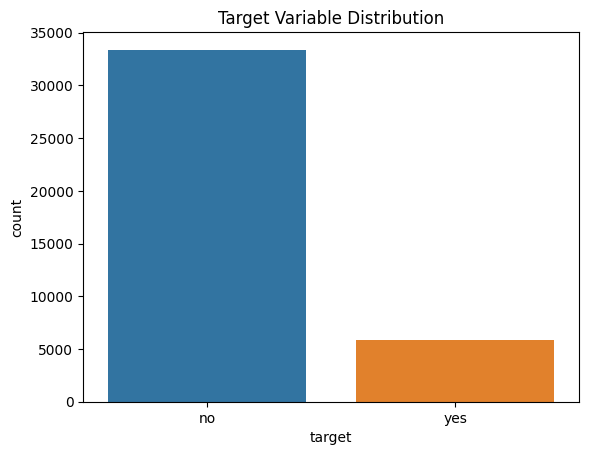

In [19]:
# Plot count of target variables
sns.countplot(data=train_data, x='target')
plt.title('Target Variable Distribution')
plt.show()

* After this plot, we can say that target variable data is heavily imbalanced, we may need to apply techniques like oversampling like SMOTE.

# Univariate Analysis

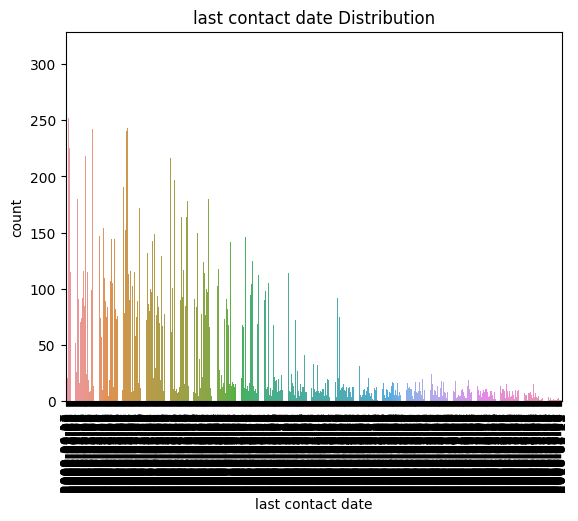

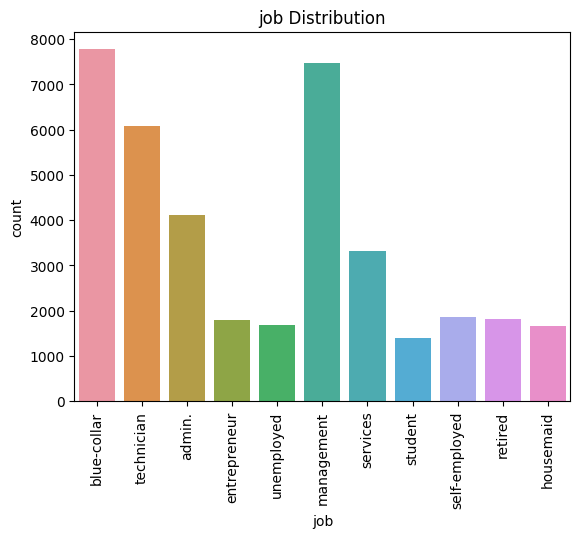

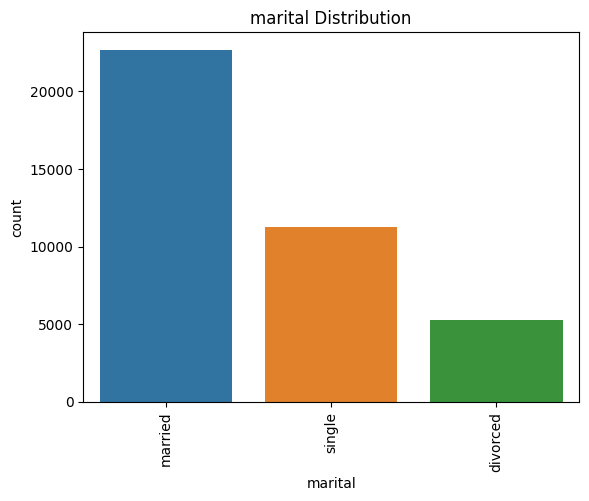

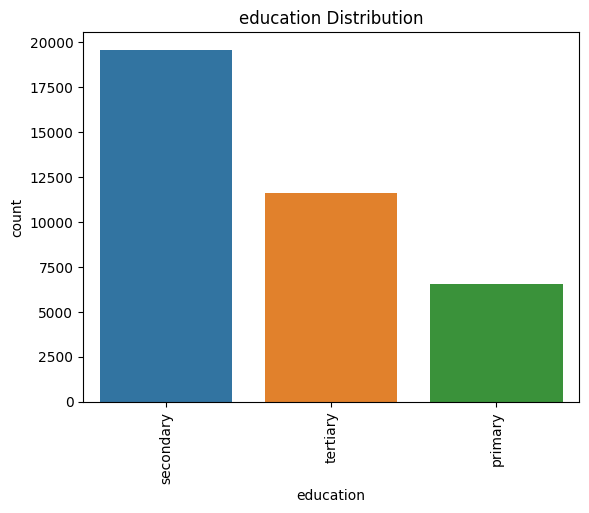

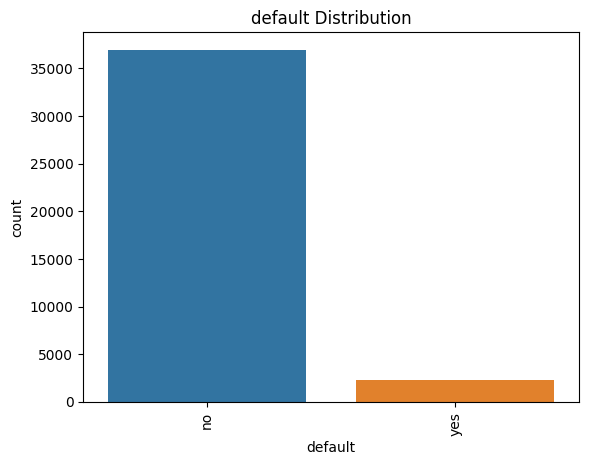

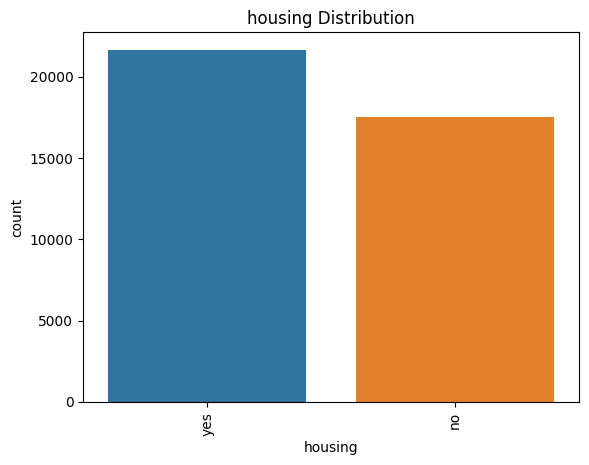

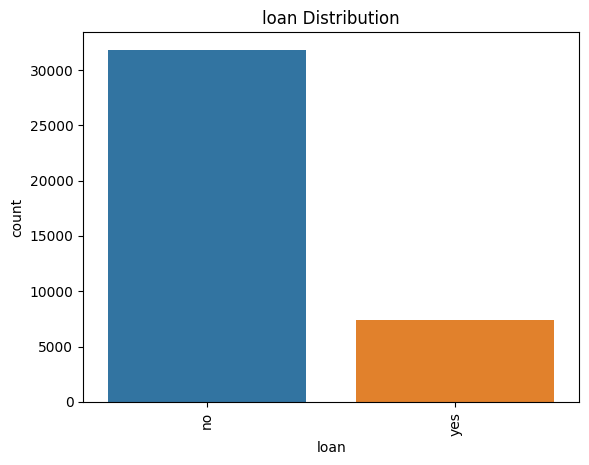

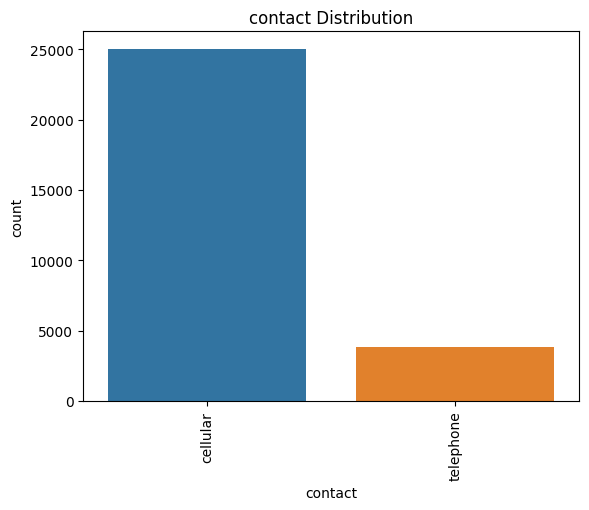

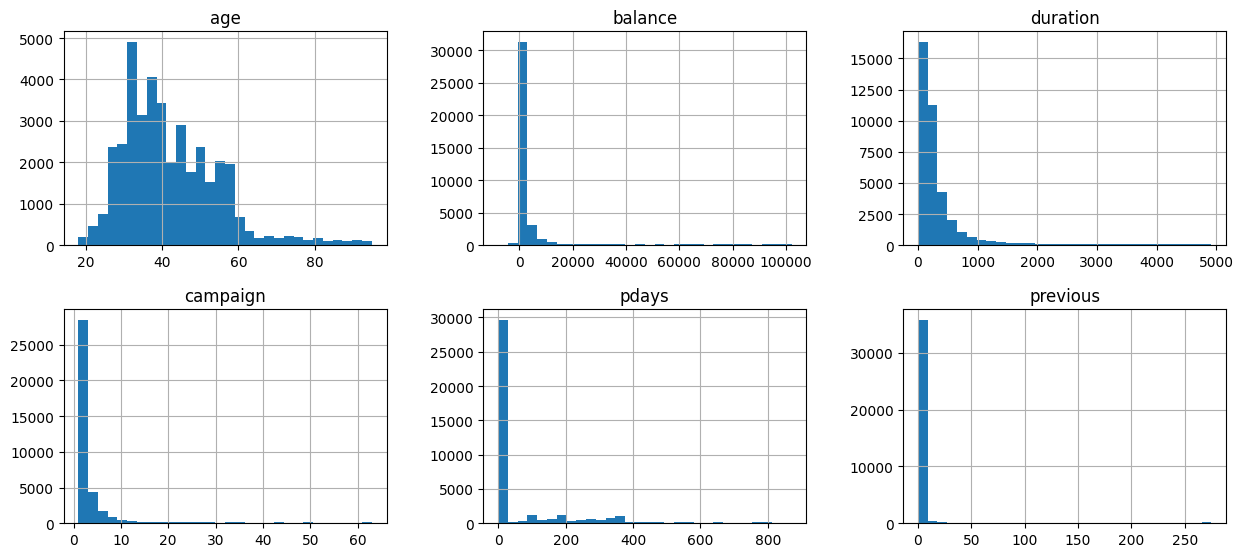

In [20]:
# Plot for each categorical variable
for col in cat_var[:8]:
    sns.countplot(x=col, data=train_data)
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=90)
    plt.show()

# Histograms for numerical columns
train_data[num_var].hist(bins=30,figsize=(15,10),layout=(3,3))
plt.show()

# Bivariate Analysis

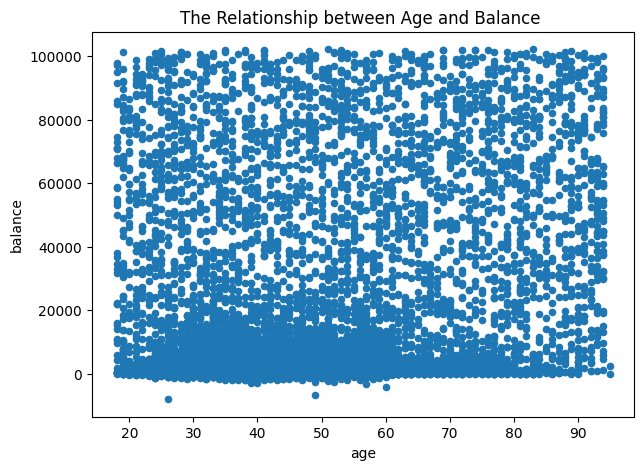

In [21]:
scatter_age_balance = train_data.plot.scatter('age','balance',figsize = (7,5))

plt.title('The Relationship between Age and Balance ')
plt.show()

Based on this scatter plot, there is no clear relationship between client’s age and balance level.

Nevertheless, over the age of 60, clients tend to have a significantly lower balance, mostly under 5,000 euros. This is due to the fact that most people retire after 60 and no longer have a reliable income source.

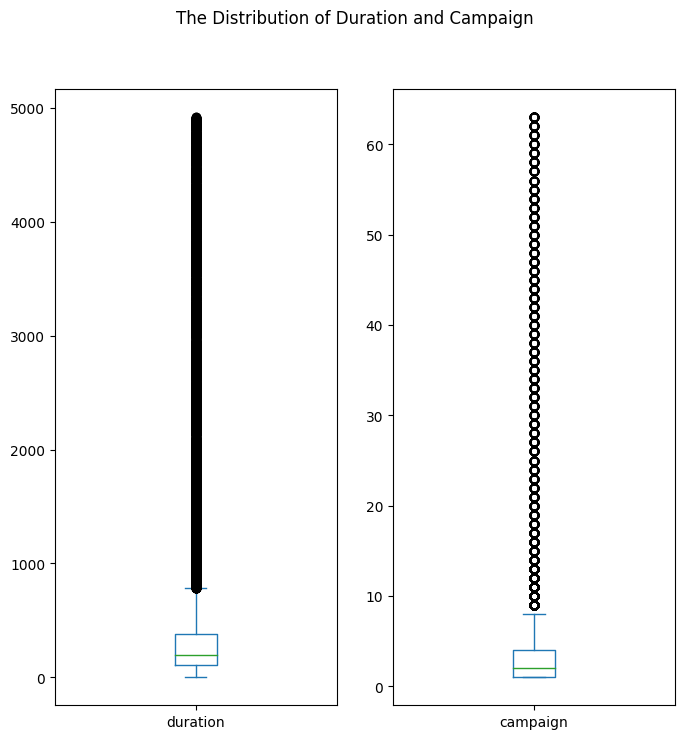

In [22]:
dist_dur_cam = train_data[['duration','campaign']].plot(kind = 'box', 
                                                      figsize = (8,8),
                                                      subplots = True, layout = (1,2),
                                                      sharex = False, sharey = False,
                                                      title='The Distribution of Duration and Campaign')
plt.show()

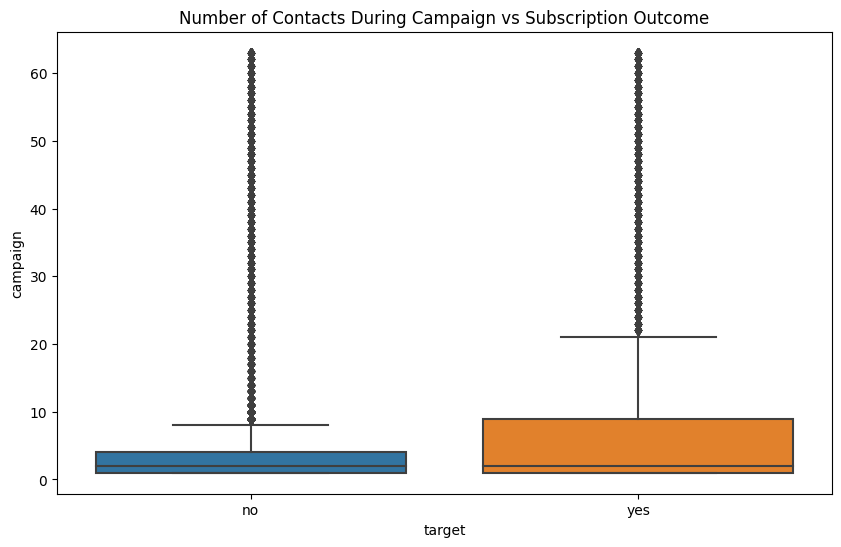

In [23]:
# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='campaign', data=train_data)
plt.title("Number of Contacts During Campaign vs Subscription Outcome")
plt.show()

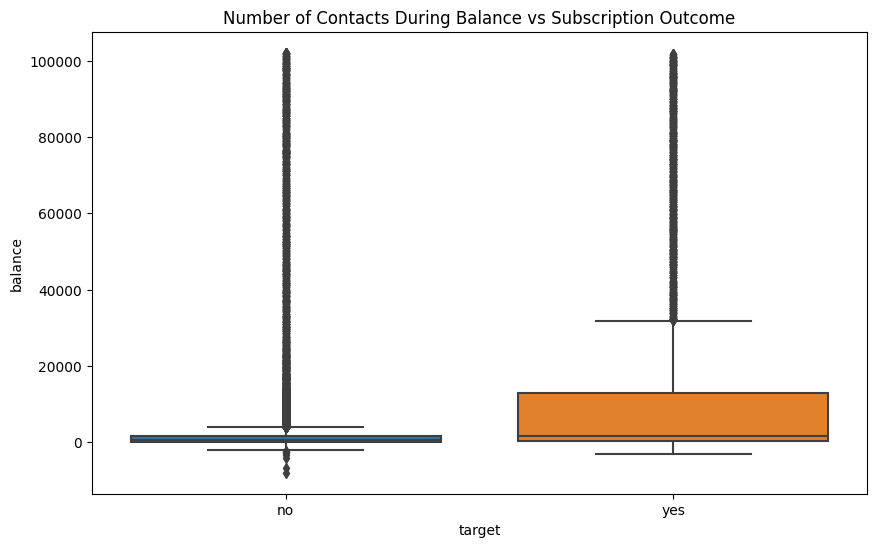

In [24]:
# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='balance', data=train_data)
plt.title("Number of Contacts During Balance vs Subscription Outcome")
plt.show()

In [25]:
# How many zero values in `balance?`
print("There are %d account holder or %f of the total clients who have zero balance" % ((train_data[train_data['balance']==0]['balance'].count()),
                                                                                         (train_data[train_data['balance']==0]['balance'].count())/(train_data['balance'].count())*100))
# How many negative values in `balance`?
print("There are %d account holder or %f of the total clients who owe money" % ((train_data[train_data['balance']<0]['balance'].count()),
                                                             (train_data[train_data['balance']<0]['balance'].count())/(train_data['balance'].count())*100))

There are 2799 account holder or 7.138303 of the total clients who have zero balance
There are 2971 account holder or 7.576955 of the total clients who owe money


In [26]:
# Is there any of those clients who subscribed to term deposit?
print("There are %d account holder who have zero balance and subscribed term deposit" % train_data[(train_data['balance']==0) & (train_data['target']=='yes')]['balance'].count())

print("There are %d account holder who have negative balance and subscribed term deposit" % train_data[(train_data['balance']<0) & (train_data['target']=='yes')]['balance'].count())

There are 235 account holder who have zero balance and subscribed term deposit
There are 156 account holder who have negative balance and subscribed term deposit


In [27]:
# The range of balance from clients who subscribed to the term deposit
print("The minimum balance to finalize a deal :", train_data[train_data['target']=='yes']['balance'].min())
print("The maximum balance to finalize a deal :", train_data[train_data['target']=='yes']['balance'].max())

The minimum balance to finalize a deal : -3058
The maximum balance to finalize a deal : 101892


In [28]:
# The range of calls duration from clients who subscribed to the term deposit
print("The minimum duration (in seconds) to finalize a deal :", train_data[train_data['target']=='yes']['duration'].min())
print("The maximum duration (in seconds) to finalize a deal :", train_data[train_data['target']=='yes']['duration'].max())

The minimum duration (in seconds) to finalize a deal : 8
The maximum duration (in seconds) to finalize a deal : 4916


In [29]:
print("How many clients who have 0 `Previous` but no `unknown` in `Poutcome`?\n",
      train_data[(train_data['previous']==0) & (train_data['poutcome']!='unknown')]['previous'].count())
print("How many clients who have `unknown` in `poutcome` but the `Previous` is not 0?\n",
      train_data[(train_data['poutcome'] == 'unknown') & (train_data['previous']!=0)]['previous'].count())

How many clients who have 0 `Previous` but no `unknown` in `Poutcome`?
 29456
How many clients who have `unknown` in `poutcome` but the `Previous` is not 0?
 0


In [30]:

# Assuming df is your DataFrame
# Check if there are any rows where pdays = -1 and previous != 0
incorrect_rows = train_data[(train_data['pdays'] == -1) & (train_data['previous'] != 0)]

# If incorrect_rows is empty, the condition is satisfied
if incorrect_rows.empty:
    print("All rows with pdays = -1 have previous = 0.")
else:
    print("There are rows where pdays = -1 but previous != 0.")
    print(incorrect_rows)

All rows with pdays = -1 have previous = 0.


In [31]:
# Check if there are any rows where previous = 0 but pdays != -1
incorrect_vice_versa = train_data[(train_data['previous'] == 0) & (train_data['pdays'] != -1)]

# If incorrect_vice_versa is empty, the vice-versa condition is satisfied
if incorrect_vice_versa.empty:
    print("All rows where previous = 0 have pdays = -1.")
else:
    print("There are rows where previous = 0 but pdays != -1.")
    

There are rows where previous = 0 but pdays != -1.


1. If pdays == -1, it indicates that the customer was not contacted in the previous campaign, so previous should be 0.


2. If previous == 0, it means no contacts were made in the previous campaign, so pdays should be -1.

In other words, these two conditions are mutually reinforcing:

If pdays == -1, then previous == 0.
If previous == 0, then pdays == -1.

In [32]:
# Correct the rows where previous = 0 but pdays != -1 by setting pdays to -1
train_data.loc[(train_data['previous'] == 0) & (train_data['pdays'] != -1), 'pdays'] = -1

# Verify if the issue is fixed
incorrect_vice_versa = train_data[(train_data['previous'] == 0) & (train_data['pdays'] != -1)]

if incorrect_vice_versa.empty:
    print("Issue fixed: All rows where previous = 0 now have pdays = -1.")
else:
    print("There are still rows with inconsistent values.")
    print(incorrect_vice_versa)

Issue fixed: All rows where previous = 0 now have pdays = -1.


In [33]:
# Is it true that if pdays is -1, then previous is 0?
print(train_data[(train_data['pdays'] != -1) & (train_data['previous']==0)]['pdays'].count() ==
train_data[(train_data['pdays'] == -1) & (train_data['previous'] != 0)]['pdays'].count())

True


In [34]:
train_data['pdays'].value_counts()

pdays
-1      29456
 182      135
 92       117
 91       106
 183      100
        ...  
 599        1
 26         1
 821        1
 852        1
 724        1
Name: count, Length: 865, dtype: int64

In [35]:
train_data['previous'].value_counts()

previous
0      29456
1       2226
2       1708
3        907
4        590
       ...  
163        5
76         5
180        5
137        5
231        4
Name: count, Length: 276, dtype: int64

In [36]:
# The relation between Previous and Campaign
print("How many rows with non-zero contact in previous campaign but zero contact in current campaign?\n", train_data[(train_data['previous'] != 0) & (train_data['campaign']==0)]['duration'].count())
print("How many rows with zero contact in previous campaign but non-zero contact in current campaign?\n", train_data[(train_data['previous'] == 0) & (train_data['campaign']!=0)]['duration'].count())

How many rows with non-zero contact in previous campaign but zero contact in current campaign?
 0
How many rows with zero contact in previous campaign but non-zero contact in current campaign?
 29456


Previous and Campaign can be combined into a single ratio feature because both features indicate the number of contacts trial in different time period, and also to minimize the multicollinearity effect between Previous and Pdays.

In [37]:
# The relation between Previous and Duration
print("How many rows with zero contact performed in previous campaign but have non-zero last contact duration?\n",
      train_data[(train_data['previous'] == 0) & (train_data['duration']!=0)]['duration'].count())
print("How many obs with non-zero contact performed in previous campaign but have zero last contact duration?\n",
      train_data[(train_data['previous'] != 0) & (train_data['duration']==0)]['duration'].count())

How many rows with zero contact performed in previous campaign but have non-zero last contact duration?
 29454
How many obs with non-zero contact performed in previous campaign but have zero last contact duration?
 0


In [38]:
# Copy the train data before preprocessing
train_data_1 = train_data.copy()

# 4. Train - Validation Split

In [39]:
# Train- Validation Split
X = train_data_1.drop('target', axis=1)
y = train_data_1['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [40]:
# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (31368, 15)
X_val shape: (7843, 15)
y_train shape: (31368,)
y_val shape: (7843,)


# 5. Preprocessing of Data

# Handling Missing Values

In [41]:
# Fill missing values in 'job', 'education' 
impute_cols = ['job', 'education']
imputer = SimpleImputer(strategy='most_frequent')
X_train[impute_cols] = imputer.fit_transform(X_train[impute_cols])
X_val[impute_cols] = imputer.transform(X_val[impute_cols])
test_data[impute_cols] = imputer.transform(test_data[impute_cols])

# Fill missing values in columns with 'unknown'
categorical_cols = ['contact', 'poutcome']
for col in categorical_cols:
    X_train[col].fillna('unknown', inplace=True)
    X_val[col].fillna('unknown', inplace=True)
    test_data[col].fillna('unknown', inplace=True)

In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31368 entries, 13800 to 15795
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  31368 non-null  object
 1   age                31368 non-null  int64 
 2   job                31368 non-null  object
 3   marital            31368 non-null  object
 4   education          31368 non-null  object
 5   default            31368 non-null  object
 6   balance            31368 non-null  int64 
 7   housing            31368 non-null  object
 8   loan               31368 non-null  object
 9   contact            31368 non-null  object
 10  duration           31368 non-null  int64 
 11  campaign           31368 non-null  int64 
 12  pdays              31368 non-null  int64 
 13  previous           31368 non-null  int64 
 14  poutcome           31368 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.8+ MB


In [43]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  10000 non-null  object
 1   age                10000 non-null  int64 
 2   job                10000 non-null  object
 3   marital            10000 non-null  object
 4   education          10000 non-null  object
 5   default            10000 non-null  object
 6   balance            10000 non-null  int64 
 7   housing            10000 non-null  object
 8   loan               10000 non-null  object
 9   contact            10000 non-null  object
 10  duration           10000 non-null  int64 
 11  campaign           10000 non-null  int64 
 12  pdays              10000 non-null  int64 
 13  previous           10000 non-null  int64 
 14  poutcome           10000 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.1+ MB


# Dealing with Outliers

In [44]:
# Remove Outliers from the balance feature in X_train
def remove_outliers(df, column, lower_percentile=0.01, upper_percentile=0.99):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    # Keep rows only within the quantile range (1st to 99th percentiles)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Cap outliers in specified features using the 99th percentile upper bound
def cap_outliers(df, column, upper_percentile):
    upper_bound = X_train[column].quantile(upper_percentile)  # Calculated from X_train only
    # Apply upper bound capping
    df[column] = df[column].clip(upper=upper_bound)
    return df

In [45]:
# Apply outlier removal to X_train for the 'balance' feature only
X_train = remove_outliers(X_train, 'balance')
y_train = y_train[X_train.index]

# List of features to apply upper bound capping
cap_settings = {
    'age': 0.99,
    'campaign':0.98,
    'previous': 0.97,
    'pdays': 0.96
}

# Apply capping to each feature in X_train, X_val, and test_data
for feature,upper_percentile in cap_settings.items():
    X_train = cap_outliers(X_train, feature,upper_percentile)
    X_val = cap_outliers(X_val, feature,upper_percentile)
    test_data = cap_outliers(test_data, feature,upper_percentile)

In [46]:
X_train['campaign'].describe()

count    30740.000000
mean         4.679733
std          8.527411
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         46.000000
Name: campaign, dtype: float64

# Feature Engineering

In [47]:
# Extracting month and day from the last contact date feature
# Convert the 'last_contact_date' to datetime format
X_train['last contact date'] = pd.to_datetime(X_train['last contact date'])
X_val['last contact date'] = pd.to_datetime(X_val['last contact date'])
test_data['last contact date'] = pd.to_datetime(test_data['last contact date'])

# Extract month and day as new columns
X_train['weekday'] = X_train['last contact date'].dt.weekday
X_train['month'] = X_train['last contact date'].dt.month
X_train['day'] = X_train['last contact date'].dt.day

X_val['weekday'] = X_val['last contact date'].dt.weekday
X_val['month'] = X_val['last contact date'].dt.month
X_val['day'] = X_val['last contact date'].dt.day

test_data['weekday'] = test_data['last contact date'].dt.weekday
test_data['month'] = test_data['last contact date'].dt.month
test_data['day'] = test_data['last contact date'].dt.day


In [48]:
# Drop 'last_contact_date' column after extracting the month and day
X_train = X_train.drop(columns=['last contact date'])
X_val = X_val.drop(columns=['last contact date'])
test_data = test_data.drop(columns=['last contact date'])

In [49]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30740 entries, 13800 to 15795
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        30740 non-null  int64  
 1   job        30740 non-null  object 
 2   marital    30740 non-null  object 
 3   education  30740 non-null  object 
 4   default    30740 non-null  object 
 5   balance    30740 non-null  int64  
 6   housing    30740 non-null  object 
 7   loan       30740 non-null  object 
 8   contact    30740 non-null  object 
 9   duration   30740 non-null  int64  
 10  campaign   30740 non-null  int64  
 11  pdays      30740 non-null  float64
 12  previous   30740 non-null  int64  
 13  poutcome   30740 non-null  object 
 14  weekday    30740 non-null  int32  
 15  month      30740 non-null  int32  
 16  day        30740 non-null  int32  
dtypes: float64(1), int32(3), int64(5), object(8)
memory usage: 3.9+ MB


In [50]:
# Binning of age feature
def preprocess_age(df):
    # Create age bins based on the provided information
    df['age_group'] = pd.cut(df['age'], bins=[0, 29, 39, 49, 59, np.inf], labels=['<30', '30-39', '40-49', '50-59', '60+'])
    
    # Drop the original 'age' column
    # df.drop(['age'], axis=1, inplace=True)
    
    return df

# Apply preprocessing on each dataset
X_train = preprocess_age(X_train)
X_val = preprocess_age(X_val)
test_data = preprocess_age(test_data)

# Display the updated training data for verification
X_train.head()


,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,weekday,month,day,age_group
13800,46,admin.,single,secondary,no,306,yes,no,cellular,289,5,-1.0,0,unknown,0,5,11,40-49
32874,43,blue-collar,married,secondary,yes,128,yes,no,cellular,71,1,-1.0,0,unknown,6,2,3,40-49
9072,32,student,single,secondary,no,0,no,no,cellular,206,1,-1.0,0,unknown,4,11,21,30-39
26803,47,services,married,secondary,no,5,no,no,cellular,169,1,-1.0,0,unknown,5,8,28,40-49
35504,45,admin.,married,secondary,no,43,no,no,cellular,114,4,-1.0,0,unknown,2,8,12,40-49


In [51]:
X_train['age_group'].value_counts()

age_group
30-39    11686
40-49     7632
50-59     5543
<30       3716
60+       2163
Name: count, dtype: int64

In [52]:
# Define a function to create the 'balance_duration_ratio' feature
def create_balance_duration_ratio(df):
    df['balance_duration_ratio'] = df['balance'] / (df['duration'] + 1)
    return df

# Apply the function to each dataset
X_train = create_balance_duration_ratio(X_train)
X_val = create_balance_duration_ratio(X_val)
test_data = create_balance_duration_ratio(test_data)

In [53]:
X_train['balance_duration_ratio'].describe()

count    30740.000000
mean        15.564945
std         85.127349
min        -47.444444
25%          0.453770
50%          2.776566
75%         10.966399
max       8720.500000
Name: balance_duration_ratio, dtype: float64

In [54]:
# Convert 'duration' from seconds to minutes and round to two decimal points
X_train['duration'] = (X_train['duration'] / 60).round(2)
X_val['duration'] = (X_val['duration'] / 60).round(2)
test_data['duration'] = (test_data['duration'] / 60).round(2)

# Drop rows in training data where 'duration' is less than 5 seconds (0.08 minutes)
X_train = X_train[X_train['duration'] >= (5 / 60)]
y_train = y_train[X_train.index]

In [55]:
# Binary feature for no previous contact
X_train['no_previous_contact'] = np.where(X_train['pdays'] == -1, 1, 0)
X_val['no_previous_contact'] = np.where(X_val['pdays'] == -1, 1, 0)
test_data['no_previous_contact'] = np.where(test_data['pdays'] == -1, 1, 0)

In [56]:
# Define a fnction to create the 'campaign_contact' feature
def create_campaign_contact(df):
    df['campaign_contact'] = df['campaign'] / (df['campaign'] + df['previous'])
    return df

# Apply the function to each dataset
X_train = create_campaign_contact(X_train)
X_val = create_campaign_contact(X_val)
test_data = create_campaign_contact(test_data)

In [57]:
# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("test shape:", test_data.shape)

X_train shape: (30700, 21)
X_val shape: (7843, 21)
y_train shape: (30700,)
y_val shape: (7843,)
test shape: (10000, 21)


# Data Visualizations

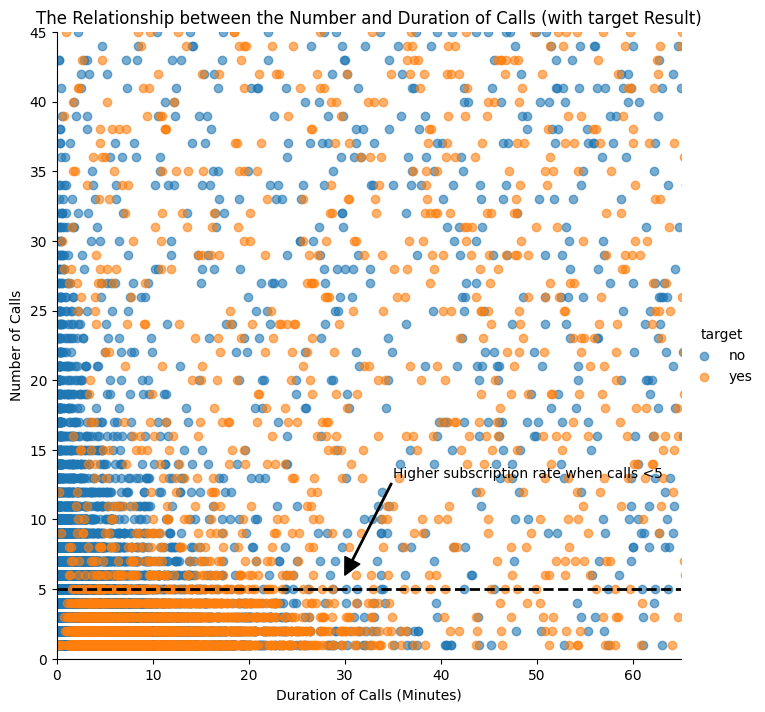

In [58]:
# Combine the features and target for visualization
train_visual = X_train.copy()
train_visual['target'] = y_train.values

# Now, visualize the relationship
import seaborn as sns
dur_cam = sns.lmplot(x='duration', y='campaign',data = train_visual,
                     hue = 'target',
                     fit_reg = False,
                     scatter_kws={'alpha':0.6}, height =7)

plt.axis([0,65,0,45])
plt.ylabel('Number of Calls')
plt.xlabel('Duration of Calls (Minutes)')
plt.title('The Relationship between the Number and Duration of Calls (with target Result)')

# Annotation
plt.axhline(y=5, linewidth=2, color="k", linestyle='--')
plt.annotate('Higher subscription rate when calls <5',xytext = (35,13),
             arrowprops=dict(color = 'k', width=1),xy=(30,6))
plt.show()

As we can see from the plot, “yes” clients and “no” clients are forming two relatively separate clusters. Compared to “no” clients”, “yes” clients were contacted by fewer times and had longer call duration. More importantly, after five campaign calls, clients are more likely to reject the term deposit unless the duration is high. Most “yes” clients were approached by less than 10 times.

This suggests that the bank should resist calling a client for more than five times, which can be disturbing and increase dissatisfaction.

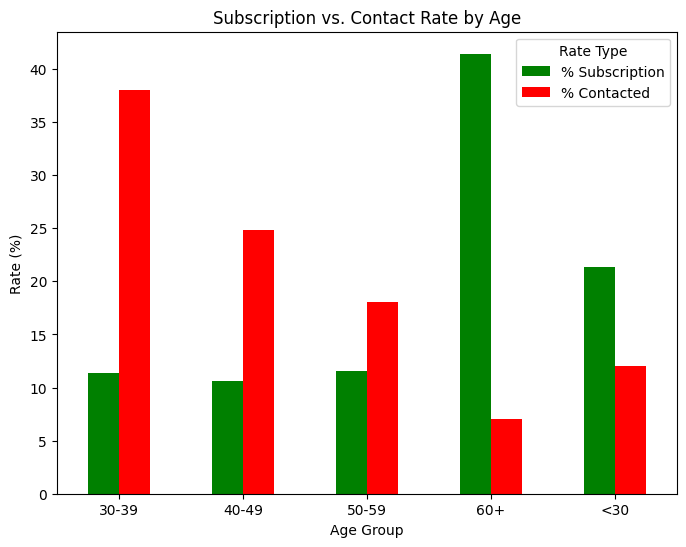

In [59]:
# Create age groups based on the 'age' column
def assign_age_group(age):
    if age < 30:
        return '<30'
    elif 30 <= age <= 39:
        return '30-39'
    elif 40 <= age <= 49:
        return '40-49'
    elif 50 <= age <= 59:
        return '50-59'
    else:
        return '60+'

# Apply the function to create 'age_group' column
train_visual['age_group'] = train_visual['age'].apply(assign_age_group)

# Calculate subscription rates by age group
count_age_response_pct = pd.crosstab(train_visual['target'], train_visual['age_group']).apply(lambda x: x / x.sum() * 100)
count_age_response_pct = count_age_response_pct.transpose()

# Create a DataFrame for plotting
age = pd.DataFrame({
    'age_group': count_age_response_pct.index,
    '% Subscription': count_age_response_pct['yes'],  # Assuming 'yes' is the positive target class
    '% Contacted': train_visual['age_group'].value_counts(normalize=True) * 100
}).set_index('age_group')

# Plotting
age.plot(kind='bar', figsize=(8, 6), color=('green', 'red'))
plt.xlabel('Age Group')
plt.ylabel('Rate (%)')
plt.title('Subscription vs. Contact Rate by Age')
plt.xticks(rotation='horizontal')
plt.legend(title='Rate Type', labels=['% Subscription', '% Contacted'])
plt.show()


Green vertical bars indicate that clients with a age of 60+ have the highest subscription rate. About 20% of the subscriptions came from the clients aged between 18 to 30. More than 50% of the subscriptions are contributed by the youngest and the eldest clients.

Red vertical bars show that the bank focused its marketing efforts irrespective of the aged group, which returned lower subscription rates than the younger and older groups. Thus, to make the marketing campaign more effective, the bank should target younger and older clients in the future.

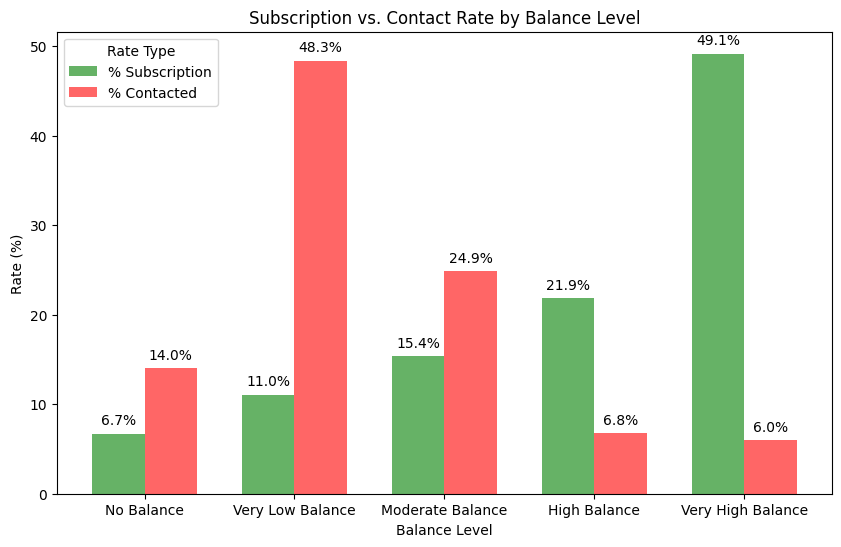

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Create balance levels based on the 'balance' column
train_visual['balance_level'] = pd.cut(train_visual['balance'], 
                                        bins=[-float('inf'), 0, 1000, 5000, 20000, float('inf')], 
                                        labels=['No Balance', 'Very Low Balance', 'Moderate Balance', 'High Balance', 'Very High Balance'])

# Calculate subscription rates by balance level
count_balance_response_pct = pd.crosstab(train_visual['target'], train_visual['balance_level']).apply(lambda x: x / x.sum() * 100)
count_balance_response_pct = count_balance_response_pct.transpose()

# Create a DataFrame for plotting
balance = pd.DataFrame({
    'balance_level': count_balance_response_pct.index,
    '% Subscription': count_balance_response_pct['yes'],  # Assuming 'yes' is the positive target class
    '% Contacted': train_visual['balance_level'].value_counts(normalize=True) * 100
}).set_index('balance_level')

# Reset index to use balance levels as a column for plotting
balance.reset_index(inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.35  # Width of the bars
x = range(len(balance))  # Create a range for the x-axis

# Plot each rate as a separate bar
plt.bar(x, balance['% Subscription'], width=bar_width, label='% Subscription', color='green', alpha=0.6)
plt.bar([p + bar_width for p in x], balance['% Contacted'], width=bar_width, label='% Contacted', color='red', alpha=0.6)

# Setting x-ticks to the balance levels
plt.xticks([p + bar_width / 2 for p in x], balance['balance_level'])
plt.xlabel('Balance Level')
plt.ylabel('Rate (%)')
plt.title('Subscription vs. Contact Rate by Balance Level')
plt.legend(title='Rate Type')

# Adding annotations for clarity
for index, row in balance.iterrows():
    plt.text(index, row['% Subscription'] + 1, f"{row['% Subscription']:.1f}%", ha='center', color='black')
    plt.text(index + bar_width, row['% Contacted'] + 1, f"{row['% Contacted']:.1f}%", ha='center', color='black')

plt.show()


Unsurprisingly, this bar chart indicates a positive correlation between clients’ balance levels and subscription rate. Clients with negative balances only returned a subscription rate of 6.8% while clients with average and high balances had significantly higher subscription rates,15% and 34.7% respectively.

However, in this campaign, about 50% of clients contacted only have a low balance level. In the future, the bank should shift its marketing focus to high-balance customers to secure more term deposits.

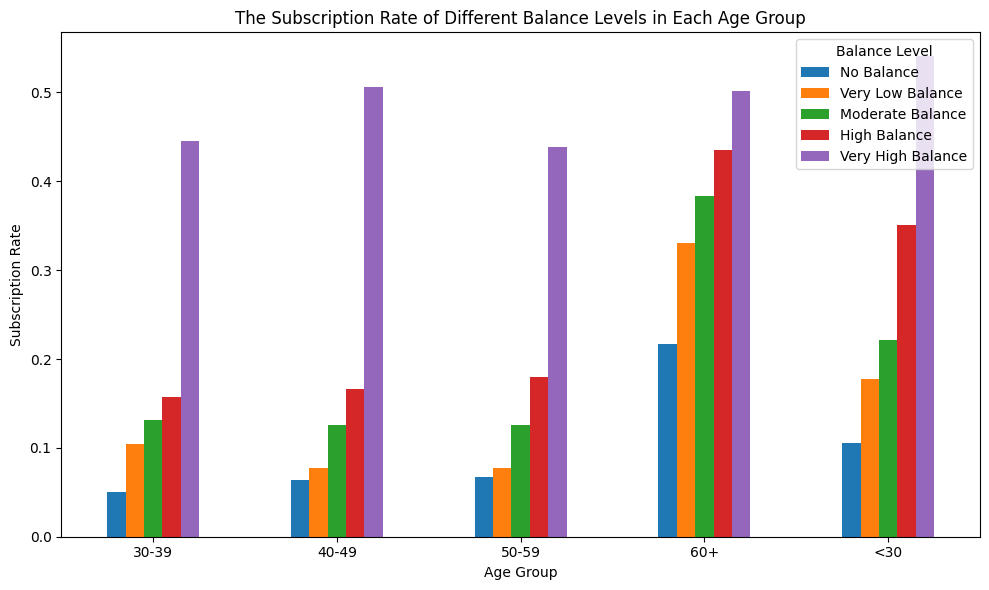

In [61]:
# Group by 'age_group' and 'balance_level' to calculate response rates
age_balance1 = train_visual.groupby(['age_group', 'balance_level'])['target'].apply(lambda x: (x == 'yes').sum())  # Count 'yes' responses
age_balance2 = train_visual.groupby(['age_group', 'balance_level'])['target'].count()  # Count total responses

# Create DataFrame for subscription rates
age_balance1 = age_balance1.reset_index(name='response_binary')
age_balance2 = age_balance2.reset_index(name='response')

# Merge the two DataFrames
age_balance = pd.merge(age_balance1, age_balance2, on=['age_group', 'balance_level'])
age_balance['response_rate'] = age_balance['response_binary'] / age_balance['response']

# Drop the unnecessary columns
age_balance = age_balance.drop(['response_binary', 'response'], axis=1)

# Unstack the DataFrame for plotting
age_balance_unstacked = age_balance.pivot(index='age_group', columns='balance_level', values='response_rate')

# Plotting
age_balance_plot = age_balance_unstacked.plot(kind='bar', figsize=(10, 6))

# Set x-ticks and labels
plt.xticks(rotation='horizontal')
plt.ylabel('Subscription Rate')
plt.xlabel('Age Group')
plt.title('The Subscription Rate of Different Balance Levels in Each Age Group')

# Set legend
plt.legend(title='Balance Level', loc='best')

# Show plot
plt.tight_layout()
plt.show()


* The graph tells the same story regarding the subscription rate for different age groups: the willingness to subscribe is exceptionally high for people aged above 60 and younger people aged below 30 also have a distinguishable higher subscription rate than those of other age groups.

* Furthermore, the effect of balance levels on subscription decision is applicable to each individual age group: every age group shares a common trend that the percentage of subscription increases with balance.

In sum, the bank should prioritize its telemarketing to clients who are above 60 years old and have positive balances, because they have the highest acceptance rate of about 45%. The next group the bank should focus on is young clients with positive balances, who showed high subscription rates between 20% and 45%.

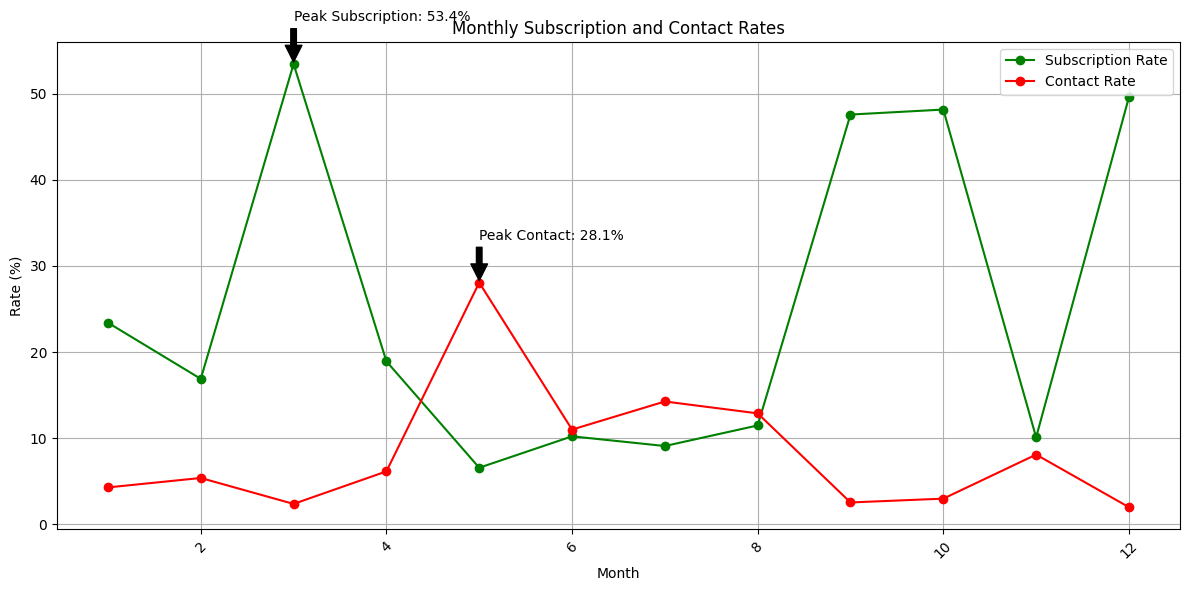

In [62]:
# Group by month to calculate subscription and contact rates
monthly_stats = train_visual.groupby('month').agg(
    total_contacts=('target', 'count'),
    total_subscriptions=('target', lambda x: (x == 'yes').sum())
).reset_index()

# Calculate subscription rate and contact rate
monthly_stats['subscription_rate'] = monthly_stats['total_subscriptions'] / monthly_stats['total_contacts'] * 100
monthly_stats['contact_rate'] = monthly_stats['total_contacts'] / monthly_stats['total_contacts'].sum() * 100  # Adjust based on total

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(monthly_stats['month'], monthly_stats['subscription_rate'], marker='o', label='Subscription Rate', color='green')
plt.plot(monthly_stats['month'], monthly_stats['contact_rate'], marker='o', label='Contact Rate', color='red')

# Finding peaks
peak_subscription_month = monthly_stats.loc[monthly_stats['subscription_rate'].idxmax()]
peak_contact_month = monthly_stats.loc[monthly_stats['contact_rate'].idxmax()]

# Annotate peaks
plt.annotate(f'Peak Subscription: {peak_subscription_month["subscription_rate"]:.1f}%', 
             xy=(peak_subscription_month['month'], peak_subscription_month['subscription_rate']),
             xytext=(peak_subscription_month['month'], peak_subscription_month['subscription_rate'] + 5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate(f'Peak Contact: {peak_contact_month["contact_rate"]:.1f}%', 
             xy=(peak_contact_month['month'], peak_contact_month['contact_rate']),
             xytext=(peak_contact_month['month'], peak_contact_month['contact_rate'] + 5),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Customize the plot
plt.title('Monthly Subscription and Contact Rates')
plt.xlabel('Month')
plt.ylabel('Rate (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


This line chart displays the clients’ response rate in each month. The subscription rate showed a different trend. The highest subscription rate occurred in March, which is over 50%, and all subscription rates in September, October, and December are over 40%.

The bank contacted most clients between May and August. The highest contact rate is around 28%, which happened in May, while the contact rate is closer to 0 in March, September, October, and December.

To improve the marketing campaign, the bank should consider initiating the telemarketing campaign in fall and spring when the subscription rate tends to be higher.

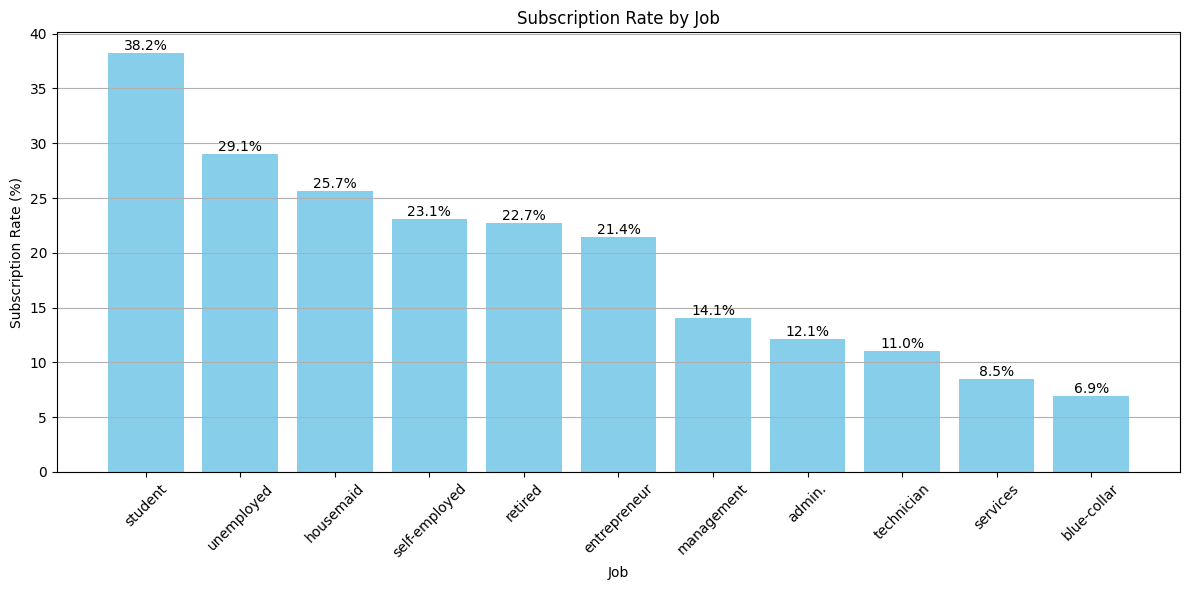

In [63]:
# Group by job to calculate total subscriptions and total counts
job_stats = train_visual.groupby('job').agg(
    total_subscriptions=('target', lambda x: (x == 'yes').sum()),
    total_contacts=('target', 'count')
).reset_index()

# Calculate subscription rate
job_stats['subscription_rate'] = job_stats['total_subscriptions'] / job_stats['total_contacts'] * 100

# Sort by subscription rate for better visualization
job_stats = job_stats.sort_values('subscription_rate', ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(job_stats['job'], job_stats['subscription_rate'], color='skyblue')

# Add titles and labels
plt.title('Subscription Rate by Job')
plt.xlabel('Job')
plt.ylabel('Subscription Rate (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Annotate the bars with subscription rates
for index, value in enumerate(job_stats['subscription_rate']):
    plt.text(index, value, f'{value:.1f}%', ha='center', va='bottom')  # Add percentage on top of the bars

plt.tight_layout()
plt.show()

As noted from the horizontal bar chart, students and unemployed clients account for more than 50% of subscription, which is consistent with the previous finding of higher subscription rates among the younger and older.

In [64]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30700 entries, 13800 to 15795
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   age                     30700 non-null  int64   
 1   job                     30700 non-null  object  
 2   marital                 30700 non-null  object  
 3   education               30700 non-null  object  
 4   default                 30700 non-null  object  
 5   balance                 30700 non-null  int64   
 6   housing                 30700 non-null  object  
 7   loan                    30700 non-null  object  
 8   contact                 30700 non-null  object  
 9   duration                30700 non-null  float64 
 10  campaign                30700 non-null  int64   
 11  pdays                   30700 non-null  float64 
 12  previous                30700 non-null  int64   
 13  poutcome                30700 non-null  object  
 14  weekday                

In [65]:
# Drop some rebundant features
def drop_features(df, columns_to_drop):
    df = df.drop(columns=columns_to_drop, errors='ignore')
    return df

columns_to_remove = ['age', 'balance_level']
X_train = drop_features(X_train, columns_to_remove)
X_val = drop_features(X_val, columns_to_remove)
test_data = drop_features(test_data, columns_to_remove)

In [66]:
X_train['age_group'].dtype

CategoricalDtype(categories=['<30', '30-39', '40-49', '50-59', '60+'], ordered=True, categories_dtype=object)

# Feature Encoding and Scaling

In [67]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30700 entries, 13800 to 15795
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   job                     30700 non-null  object  
 1   marital                 30700 non-null  object  
 2   education               30700 non-null  object  
 3   default                 30700 non-null  object  
 4   balance                 30700 non-null  int64   
 5   housing                 30700 non-null  object  
 6   loan                    30700 non-null  object  
 7   contact                 30700 non-null  object  
 8   duration                30700 non-null  float64 
 9   campaign                30700 non-null  int64   
 10  pdays                   30700 non-null  float64 
 11  previous                30700 non-null  int64   
 12  poutcome                30700 non-null  object  
 13  weekday                 30700 non-null  int32   
 14  month                  

In [68]:
# Define categorical and numerical columns
one_hot_cols = ['job', 'poutcome', 'contact', 'marital', 'education']
label_cols = ['default', 'housing', 'loan'] 
ordinal_col = ['age_group']
numerical_cols = ['balance','duration','campaign','pdays','previous','campaign_contact','balance_duration_ratio']

# Initialize LabelEncoders for binary columns
label_encoders = {col: LabelEncoder() for col in label_cols}
target_encoder = LabelEncoder()

# Fit and transform the label columns in the training set
for col in label_cols:
    X_train[col] = label_encoders[col].fit_transform(X_train[col])
    X_val[col] = label_encoders[col].transform(X_val[col])
    test_data[col] = label_encoders[col].transform(test_data[col])

# Fit and transform the target variable
y_train_tf = target_encoder.fit_transform(y_train)
y_val_tf = target_encoder.transform(y_val)

# Create the ColumnTransformer for the remaining columns
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), one_hot_cols),
        ('ordinal', OrdinalEncoder(), ordinal_col),
        ('scaler', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'  # To keep other columns unchanged if any
)

# Fit the preprocessor on the training data and transform all datasets
X_train_final = preprocessor.fit_transform(X_train)
X_val_final = preprocessor.transform(X_val)
test_final = preprocessor.transform(test_data)

# Convert the transformed arrays to DataFrames
# Get feature names after transformation
feature_names = preprocessor.get_feature_names_out()
X_train_tf = pd.DataFrame(X_train_final, columns=feature_names)
X_val_tf = pd.DataFrame(X_val_final, columns=feature_names)
test_tf = pd.DataFrame(test_final, columns=feature_names)

# Now, X_train_transformed, X_val_transformed, and X_test_transformed are ready for model training
print(f'Transformed X_train shape: {X_train_tf.shape}')
print(f'Transformed X_val shape: {X_val_tf.shape}')
print(f'Transformed y_train shape: {y_train_tf.shape}')
print(f'Transformed y_val shape: {y_val_tf.shape}')
print(f'Transformed test shape: {test_tf.shape}')

Transformed X_train shape: (30700, 39)
Transformed X_val shape: (7843, 39)
Transformed y_train shape: (30700,)
Transformed y_val shape: (7843,)
Transformed test shape: (10000, 39)


In [69]:
X_train_tf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30700 entries, 0 to 30699
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   onehot__job_admin.              30700 non-null  float64
 1   onehot__job_blue-collar         30700 non-null  float64
 2   onehot__job_entrepreneur        30700 non-null  float64
 3   onehot__job_housemaid           30700 non-null  float64
 4   onehot__job_management          30700 non-null  float64
 5   onehot__job_retired             30700 non-null  float64
 6   onehot__job_self-employed       30700 non-null  float64
 7   onehot__job_services            30700 non-null  float64
 8   onehot__job_student             30700 non-null  float64
 9   onehot__job_technician          30700 non-null  float64
 10  onehot__job_unemployed          30700 non-null  float64
 11  onehot__poutcome_failure        30700 non-null  float64
 12  onehot__poutcome_other          

# 6. Feature Selection

In [70]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import RFECV
# from sklearn.model_selection import StratifiedKFold
# import matplotlib.pyplot as plt

# # Initialize the estimator
# rf_estimator = RandomForestClassifier(random_state=42)

# # Initialize RFECV with the random forest estimator
# # cv=5 specifies 5-fold cross-validation, and step=1 eliminates one feature per iteration
# rfecv = RFECV(estimator=rf_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)

# # Fit RFECV to the training data
# rfecv.fit(X_train_tf, y_train_tf)

# # The optimal number of features
# optimal_num_features = rfecv.n_features_

# print(f"Optimal number of features: {optimal_num_features}")

In [71]:
# Initialize the RandomForestClassifier
rf_estimator = RandomForestClassifier(random_state=42)

# Specify the number of features you want to select
num_features_to_select = 28  # Change this to your desired number of features

# Initialize RFE with the random forest estimator
rfe_selector = RFE(estimator=rf_estimator, n_features_to_select=num_features_to_select, step=1)

# Fit RFE to the training data
rfe_selector.fit(X_train_tf, y_train_tf)

# Get the selected feature names
selected_features = X_train_tf.columns[rfe_selector.support_]
print("Selected Features:")
print(selected_features)

# Optionally, transform the dataset to keep only the selected features
X_train_selected = pd.DataFrame(rfe_selector.transform(X_train_tf), columns=selected_features)
X_val_selected = pd.DataFrame(rfe_selector.transform(X_val_tf), columns=selected_features)
test_selected = pd.DataFrame(rfe_selector.transform(test_tf), columns=selected_features)

print(f'Transformed X_train shape: {X_train_selected.shape}')
print(f'Transformed X_val shape: {X_val_selected.shape}')
print(f'Transformed test shape: {test_selected.shape}')

Selected Features:
Index(['onehot__job_blue-collar', 'onehot__job_management',
       'onehot__job_technician', 'onehot__poutcome_failure',
       'onehot__poutcome_success', 'onehot__poutcome_unknown',
       'onehot__contact_cellular', 'onehot__contact_unknown',
       'onehot__marital_divorced', 'onehot__marital_married',
       'onehot__marital_single', 'onehot__education_primary',
       'onehot__education_secondary', 'onehot__education_tertiary',
       'ordinal__age_group', 'scaler__balance', 'scaler__duration',
       'scaler__campaign', 'scaler__pdays', 'scaler__previous',
       'scaler__campaign_contact', 'scaler__balance_duration_ratio',
       'remainder__housing', 'remainder__loan', 'remainder__weekday',
       'remainder__month', 'remainder__day', 'remainder__no_previous_contact'],
      dtype='object')
Transformed X_train shape: (30700, 28)
Transformed X_val shape: (7843, 28)
Transformed test shape: (10000, 28)


# 7. Class Imbalance

In [72]:
# from imblearn.combine import SMOTEENN

# # Initialize SMOTEEN
# smoteen = SMOTEENN(random_state=42)

# # Apply SMOTEEN on the training data
# X_resampled, y_resampled = smoteen.fit_resample(X_train_selected, y_train_tf)

# # Display the shape of the resampled data
# print(f"Resampled X shape: {X_resampled.shape}")
# print(f"Resampled y shape: {y_resampled.shape}")
# y_resampled_series = pd.Series(y_resampled)
# print(f"Class distribution after resampling:\n{y_resampled_series.value_counts()}")

# print(f"Original class distribution: {y.value_counts()}")

# 8. Dummy Model

In [73]:
from sklearn.dummy import DummyClassifier
# Initialize the model
dummy_class =DummyClassifier(strategy = 'most_frequent')

# Train the model
dummy_class.fit(X_train_selected,y_train_tf)

# Make predictions on the val set
y_pred = dummy_class.predict(X_val_selected)

# Evaluate the model
accuracy = accuracy_score(y_val_tf, y_pred)
print(f'Accuracy: {accuracy}')
print("\nClassification Report:\n", classification_report(y_val_tf, y_pred))

Accuracy: 0.847252326915721

Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92      6645
           1       0.00      0.00      0.00      1198

    accuracy                           0.85      7843
   macro avg       0.42      0.50      0.46      7843
weighted avg       0.72      0.85      0.78      7843



# 9. Baseline Model

Accuracy: 0.8193293382634196

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.84      0.89      6645
           1       0.44      0.72      0.55      1198

    accuracy                           0.82      7843
   macro avg       0.69      0.78      0.72      7843
weighted avg       0.87      0.82      0.84      7843



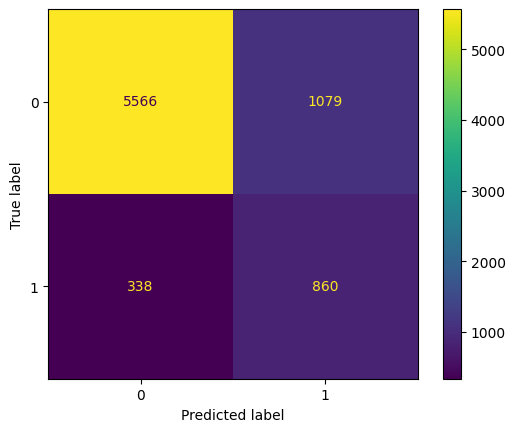

In [74]:
# Initialize the model
model_1 = LogisticRegression(random_state = 42, class_weight='balanced', max_iter = 1000)

# Train the model
model_1.fit(X_train_selected,y_train_tf)

# Make predictions on the val set
y_pred = model_1.predict(X_val_selected)

# Evaluate the model
accuracy = accuracy_score(y_val_tf, y_pred)
print(f'Accuracy: {accuracy}')
print("\nClassification Report:\n", classification_report(y_val_tf, y_pred))

cm = confusion_matrix(y_val_tf, y_pred, labels=model_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_1.classes_)
disp.plot()

# 10. Fitting Different Models

In [75]:
# Calculate scale_pos_weight
scale_pos_weight = len(y_train_tf[y_train_tf == 0]) / len(y_train_tf[y_train_tf == 1])
print(scale_pos_weight)

5.88032272523532


Accuracy: 0.8602575545072039

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.87      0.91      6645
           1       0.53      0.80      0.64      1198

    accuracy                           0.86      7843
   macro avg       0.74      0.84      0.78      7843
weighted avg       0.89      0.86      0.87      7843



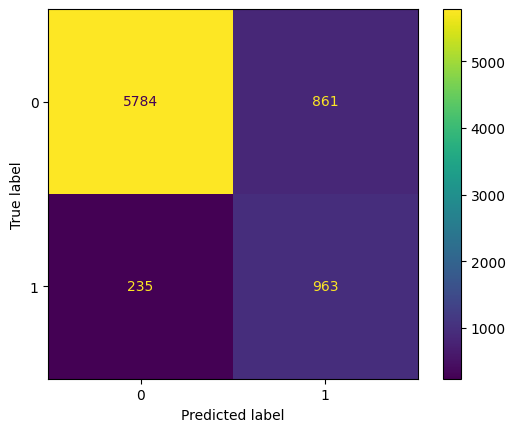

In [76]:
# Inilialize the model
model_2 = xgb.XGBClassifier(random_state = 42, scale_pos_weight = scale_pos_weight, subsample = 0.7, n_estimators = 300, min_child_weight = 5, max_depth = 9, learning_rate = 0.05, colsample_bytree = 0.7)

# Train the model
model_2.fit(X_train_selected,y_train_tf)

# Make predictions on the val set
y_pred = model_2.predict(X_val_selected)

# Evaluate the model
accuracy = accuracy_score(y_val_tf, y_pred)
print(f'Accuracy: {accuracy}')
print("\nClassification Report:\n", classification_report(y_val_tf, y_pred))

cm = confusion_matrix(y_val_tf, y_pred, labels=model_2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_2.classes_)
disp.plot()

In [77]:
# # Define parameter distribution
# param_dist = {
#     'n_estimators': [300, 400, 500, 600, 700],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'max_depth': [3, 5, 7, 9],
#     'min_child_weight': [1, 3, 5, 7],
#     'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
#     'subsample': [0.7, 0.8, 0.9, 1.0],
# }

# # Initialize the model
# model = xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight)

# # Set up RandomizedSearchCV with scoring='f1_macro'
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=50,  # Number of random combinations to try
#     scoring='f1_macro',
#     cv=5,
#     verbose=1,  # Shows a summary of the search
#     n_jobs=-1,
#     random_state=42
# )

# # Fit on training data
# random_search.fit(X_train_selected, y_train_tf)

# # Best parameters and F1 macro score
# print(f"Best parameters found: {random_search.best_params_}")
# print(f"Best F1 macro score: {random_search.best_score_}")

# # Evaluate the best model on the validation set
# best_model = random_search.best_estimator_
# y_pred = best_model.predict(X_val_selected)
# print("\nValidation Classification Report:\n", classification_report(y_val_tf, y_pred))

# # Plot confusion matrix
# cm = confusion_matrix(y_val_tf, y_pred, labels=best_model.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
# disp.plot()

In [78]:
# # Initialize the model 
# model_3 = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform' , metric = 'euclidean')

# # Train the model
# model_3.fit(X_train_selected,y_train_tf)

# # Make predictions on the val set
# y_pred = model_3.predict(X_val_selected)

# # Evaluate the model
# accuracy = accuracy_score(y_val_tf, y_pred)
# print(f'Accuracy: {accuracy}')
# print("\nClassification Report:\n", classification_report(y_val_tf, y_pred))

# cm = confusion_matrix(y_val_tf, y_pred, labels=model_3.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_3.classes_)
# disp.plot()

In [79]:
# from sklearn.pipeline import make_pipeline
# # Initialize the model
# model_4 = SGDClassifier(random_state = 42,max_iter=1000, tol=1e-3,early_stopping=True)

# # Train the model
# model_4.fit(X_train_selected,y_train_tf)

# # Make predictions on the val set
# y_pred = model_4.predict(X_val_selected)

# # Evaluate the model
# accuracy = accuracy_score(y_val_tf, y_pred)
# print(f'Accuracy: {accuracy}')
# print("\nClassification Report:\n", classification_report(y_val_tf, y_pred))

# cm = confusion_matrix(y_val_tf, y_pred, labels=model_4.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_4.classes_)
# disp.plot()

Accuracy: 0.865867652683922

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.92      6645
           1       0.54      0.77      0.64      1198

    accuracy                           0.87      7843
   macro avg       0.75      0.83      0.78      7843
weighted avg       0.89      0.87      0.87      7843



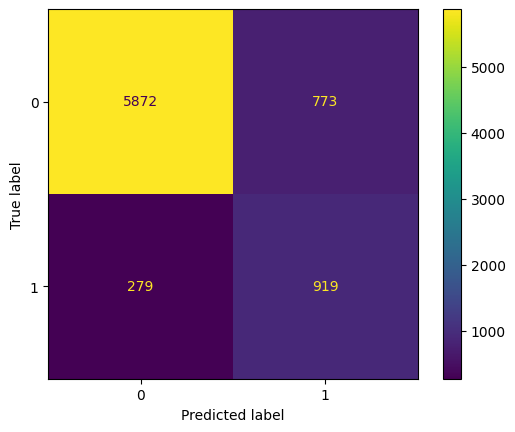

In [80]:
# Initialize the model
model_5 = lgb.LGBMClassifier(is_unbalance = True, subsample = 0.8, num_leaves = 100, n_estimators = 500, max_depth = 20, learning_rate = 0.05, colsample_bytree = 0.7, force_row_wise = True, verbose = -1)

# Train the model
model_5.fit(X_train_selected,y_train_tf)

# Make predictions on the val set
y_pred = model_5.predict(X_val_selected)

# Evaluate the model
accuracy = accuracy_score(y_val_tf, y_pred)
print(f'Accuracy: {accuracy}')
print("\nClassification Report:\n", classification_report(y_val_tf, y_pred))

cm = confusion_matrix(y_val_tf, y_pred, labels=model_5.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_5.classes_)
disp.plot()

In [81]:
# # Define parameter distributions
# param_dist = {
#     'n_estimators': [300, 500, 700, 1000],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'max_depth': [10, 15, 20, 25, -1],
#     'num_leaves': [20, 50, 100, 150],
#     'subsample': [0.6, 0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
# }

# # Initialize the model
# model = lgb.LGBMClassifier(is_unbalance=True, force_row_wise=True, random_state=42, verbose=-1)

# # Set up RandomizedSearchCV with scoring='f1_macro'
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=50,  # Number of random combinations to try
#     scoring='f1_macro',
#     cv=5,
#     verbose=1,  # Shows a summary of the search
#     n_jobs=-1,
#     random_state=42
# )

# # Fit on training data
# random_search.fit(X_train_selected, y_train_tf)

# # Best parameters and F1 macro score
# print(f"Best parameters found: {random_search.best_params_}")
# print(f"Best F1 macro score: {random_search.best_score_}")

# # Evaluate the best model on the validation set
# best_model = random_search.best_estimator_
# y_pred = best_model.predict(X_val_selected)
# print("\nValidation Classification Report:\n", classification_report(y_val_tf, y_pred))

# # Plot confusion matrix
# cm = confusion_matrix(y_val_tf, y_pred, labels=best_model.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
# disp.plot()


Accuracy: 0.8090016575290068

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.80      0.88      6645
           1       0.44      0.86      0.58      1198

    accuracy                           0.81      7843
   macro avg       0.70      0.83      0.73      7843
weighted avg       0.89      0.81      0.83      7843



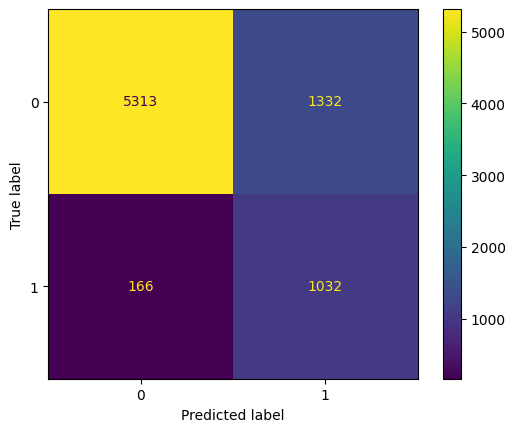

In [82]:
# Initialize the model
model_6 = DecisionTreeClassifier(random_state=42,class_weight = 'balanced', max_depth=10, min_samples_split=50, min_samples_leaf=10, criterion='gini')

# Train the model
model_6.fit(X_train_selected,y_train_tf)

# Make predictions on the val set
y_pred = model_6.predict(X_val_selected)

# Evaluate the model
accuracy = accuracy_score(y_val_tf, y_pred)
print(f'Accuracy: {accuracy}')
print("\nClassification Report:\n", classification_report(y_val_tf, y_pred))

cm = confusion_matrix(y_val_tf, y_pred, labels=model_6.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_6.classes_)
disp.plot()

In [83]:
# # Initialize the model
# model_7 = svm.LinearSVC()

# # Train the model
# model_7.fit(X_train_selected,y_train_tf)

# # Make predictions on the val set
# y_pred = model_7.predict(X_val_selected)

# # Evaluate the model
# accuracy = accuracy_score(y_val_tf, y_pred)
# print(f'Accuracy: {accuracy}')
# print("\nClassification Report:\n", classification_report(y_val_tf, y_pred))

# cm = confusion_matrix(y_val_tf, y_pred, labels=model_7.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_7.classes_)
# disp.plot()

In [84]:
# # Initialize the model
# model_8 = GaussianNB()

# # Train the model
# model_8.fit(X_train_selected,y_train_tf)

# # Make predictions on the val set
# y_pred = model_8.predict(X_val_selected)

# # Evaluate the model
# accuracy = accuracy_score(y_val_tf, y_pred)
# print(f'Accuracy: {accuracy}')
# print("\nClassification Report:\n", classification_report(y_val_tf, y_pred))

# cm = confusion_matrix(y_val_tf, y_pred, labels=model_8.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_8.classes_)
# disp.plot()

In [85]:
# from sklearn.neural_network import MLPClassifier
# # Multi-layer Perceptron
# model_9 = MLPClassifier(random_state=42, max_iter=100, early_stopping=True)

# # Train the model
# model_9.fit(X_train_selected,y_train_tf)

# # Make predictions on the val set
# y_pred = model_9.predict(X_val_selected)

# # Evaluate the model
# accuracy = accuracy_score(y_val_tf, y_pred)
# print(f'Accuracy: {accuracy}')
# print("\nClassification Report:\n", classification_report(y_val_tf, y_pred))

# cm = confusion_matrix(y_val_tf, y_pred, labels=model_9.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_9.classes_)
# disp.plot()

Accuracy: 0.8647201326023205

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.92      6645
           1       0.54      0.76      0.63      1198

    accuracy                           0.86      7843
   macro avg       0.75      0.82      0.77      7843
weighted avg       0.89      0.86      0.87      7843



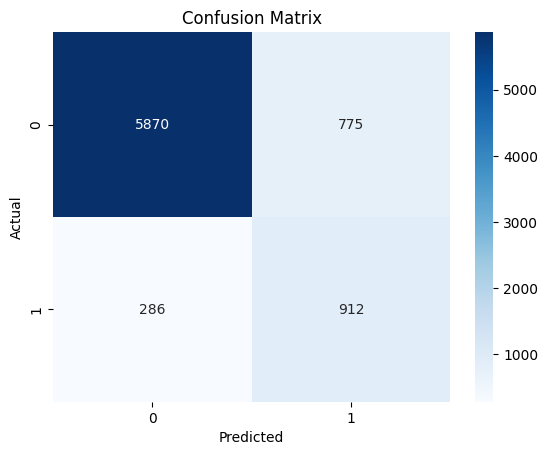

In [86]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest Classifier
model_10 = RandomForestClassifier(class_weight='balanced', n_estimators = 300, random_state=42, min_samples_split = 5, min_samples_leaf = 4)

# Train the model
model_10.fit(X_train_selected,y_train_tf)

# Make predictions on the validation set
y_pred = model_10.predict(X_val_selected)

# Evaluate the model
accuracy = accuracy_score(y_val_tf, y_pred)
print(f'Accuracy: {accuracy}')

# Print classification report
print("\nClassification Report:\n", classification_report(y_val_tf, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_val_tf, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_10.classes_, yticklabels=model_10.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [87]:

# # Define parameter distributions for RandomizedSearchCV
# param_dist = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# # Initialize the Random Forest model
# model = RandomForestClassifier(class_weight='balanced', random_state=42)

# # Set up RandomizedSearchCV with scoring='f1_macro'
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=50,  # Number of random combinations to try
#     scoring='f1_macro',
#     cv=3,
#     verbose=1,  # Shows a summary of the search
#     n_jobs=-1,
#     random_state=42
# )

# # Fit on training data
# random_search.fit(X_train_selected, y_train_tf)

# # Best parameters and F1 macro score
# print(f"Best parameters found: {random_search.best_params_}")
# print(f"Best F1 macro score: {random_search.best_score_}")

In [88]:
# # Adaboost
# from sklearn.ensemble import AdaBoostClassifier

# model_11 = AdaBoostClassifier(random_state=42, n_estimators = 300)

# # Train the model
# model_11.fit(X_train_selected,y_train_tf)

# # Make predictions on the val set
# y_pred = model_11.predict(X_val_selected)

# # Evaluate the model
# accuracy = accuracy_score(y_val_tf, y_pred)
# print(f'Accuracy: {accuracy}')
# print("\nClassification Report:\n", classification_report(y_val_tf, y_pred))

# cm = confusion_matrix(y_val_tf, y_pred, labels=model_11.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_9.classes_)
# disp.plot()

# 11. Model Selection

Evaluating XGBoost (model_2) with 10-fold Cross-Validation...
Cross-Validation F1 Macro Scores: [0.7890458  0.77110237 0.75922845 0.77140925 0.76808925 0.767059
 0.77522304 0.77791973 0.77148494 0.78782374]
Mean F1 Macro (CV): 0.7738, Std Dev: 0.0087

Evaluating LightGBM (model_5) with 10-fold Cross-Validation...
Cross-Validation F1 Macro Scores: [0.79699359 0.77754645 0.75801649 0.76841025 0.77033972 0.76882678
 0.7785806  0.77594119 0.76444376 0.78445782]
Mean F1 Macro (CV): 0.7744, Std Dev: 0.0105

Evaluating Decision Tree (model_6) with 10-fold Cross-Validation...
Cross-Validation F1 Macro Scores: [0.74566426 0.73180095 0.72124013 0.71238064 0.73749491 0.73553133
 0.73034323 0.73462922 0.73427634 0.74282655]
Mean F1 Macro (CV): 0.7326, Std Dev: 0.0093

Evaluating Random Forest (model_10) with 10-fold Cross-Validation...
Cross-Validation F1 Macro Scores: [0.78253743 0.76653466 0.76161441 0.76206642 0.76029567 0.76770729
 0.7734942  0.78041628 0.77009253 0.7809898 ]
Mean F1 Macro (CV

<Figure size 1200x600 with 0 Axes>

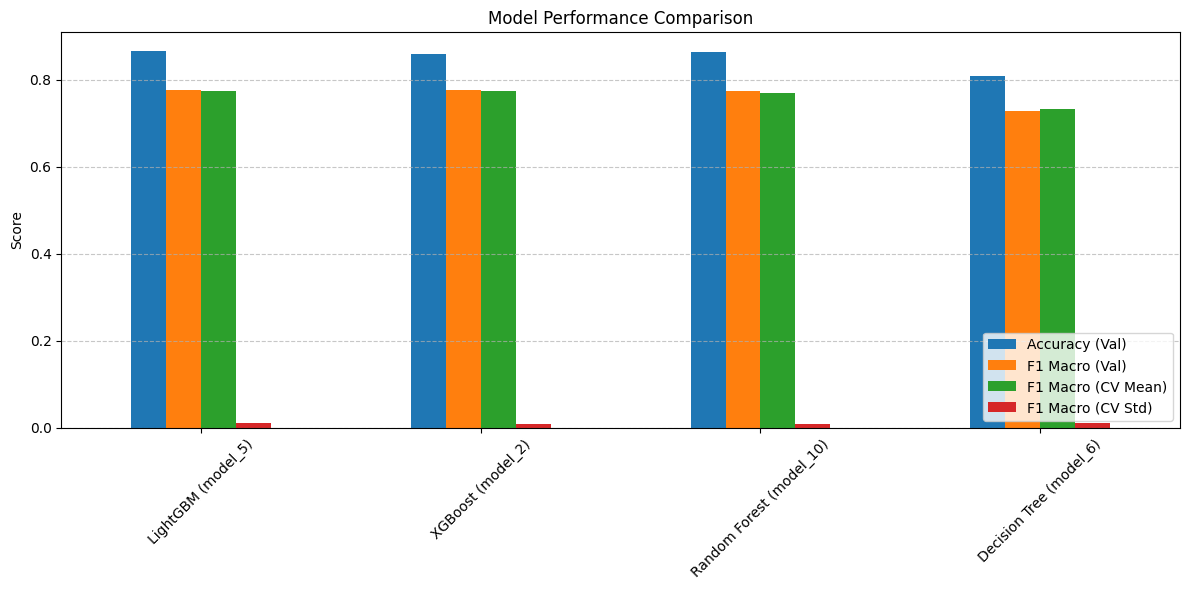

Model Performance Insights:
The best-performing model based on CV mean F1 Macro score is LightGBM (model_5) with a score of 0.7744.

Detailed Performance Metrics:
                           Accuracy (Val)  F1 Macro (Val)  F1 Macro (CV Mean)  \
XGBoost (model_2)               0.860258        0.775391            0.773839   
LightGBM (model_5)              0.865868        0.776886            0.774356   
Decision Tree (model_6)         0.809002        0.727947            0.732619   
Random Forest (model_10)        0.864720        0.774676            0.770575   

                          F1 Macro (CV Std)  
XGBoost (model_2)                  0.008700  
LightGBM (model_5)                 0.010451  
Decision Tree (model_6)            0.009265  
Random Forest (model_10)           0.008000  


In [89]:
# Define a function to evaluate and visualize model performance with cross-validation
def evaluate_model_cv(model, model_name, X_train, y_train, X_val, y_val, metrics_df, cv=5):
    print(f"Evaluating {model_name} with {cv}-fold Cross-Validation...")
    
    # Perform cross-validation on the training data
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=skf, n_jobs=-1)
    
    # Train the model on the full training data
    model.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    f1_macro = f1_score(y_val, y_pred, average='macro')
    accuracy = accuracy_score(y_val, y_pred)
    
    # Update metrics DataFrame
    metrics_df.loc[model_name] = [accuracy, f1_macro, np.mean(cv_scores), np.std(cv_scores)]
    
    # Print classification report
    # print(f"\n{model_name} Classification Report:\n", classification_report(y_val, y_pred))
    
    # Plot confusion matrix
    # cm = confusion_matrix(y_val, y_pred, labels=model.classes_)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    # disp.plot(cmap='Blues')
    # plt.title(f"{model_name} - Confusion Matrix")
    # plt.show()
    
    print(f"Cross-Validation F1 Macro Scores: {cv_scores}")
    print(f"Mean F1 Macro (CV): {np.mean(cv_scores):.4f}, Std Dev: {np.std(cv_scores):.4f}\n")
    
    return metrics_df

# Prepare an empty DataFrame to store model performance metrics
metrics_df = pd.DataFrame(columns=['Accuracy (Val)', 'F1 Macro (Val)', 'F1 Macro (CV Mean)', 'F1 Macro (CV Std)'])

# Evaluate models using cross-validation
metrics_df = evaluate_model_cv(model_2, "XGBoost (model_2)", X_train_selected, y_train_tf, X_val_selected, y_val_tf, metrics_df, cv=10)
metrics_df = evaluate_model_cv(model_5, "LightGBM (model_5)", X_train_selected, y_train_tf, X_val_selected, y_val_tf, metrics_df, cv=10)
metrics_df = evaluate_model_cv(model_6, "Decision Tree (model_6)", X_train_selected, y_train_tf, X_val_selected, y_val_tf, metrics_df, cv=10)
metrics_df = evaluate_model_cv(model_10, "Random Forest (model_10)", X_train_selected, y_train_tf, X_val_selected, y_val_tf, metrics_df, cv=10)

# Plot performance comparison
plt.figure(figsize=(12, 6))
metrics_df.sort_values('F1 Macro (Val)', ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print insights
print("Model Performance Insights:")
best_model = metrics_df['F1 Macro (CV Mean)'].idxmax()
print(f"The best-performing model based on CV mean F1 Macro score is {best_model} with a score of {metrics_df.loc[best_model, 'F1 Macro (CV Mean)']:.4f}.")
print("\nDetailed Performance Metrics:\n", metrics_df)


# 12. Train whole data

In [90]:
# Combine training and validation sets for full training
X_full_train = np.vstack((X_train_selected, X_val_selected))
y_full_train = np.concatenate((y_train_tf, y_val_tf))

# Fit the model on the full training data
model_5.fit(X_full_train, y_full_train)

# Predict on the validation set to evaluate
y_pred = model_5.predict(X_val_selected)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_val_tf, y_pred)
print(f'Accuracy: {accuracy}')
print("\nClassification Report:\n", classification_report(y_val_tf, y_pred))


Accuracy: 0.9472140762463344

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      6645
           1       0.74      1.00      0.85      1198

    accuracy                           0.95      7843
   macro avg       0.87      0.97      0.91      7843
weighted avg       0.96      0.95      0.95      7843



# 13. Submission

In [91]:
test_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   onehot__job_blue-collar         10000 non-null  float64
 1   onehot__job_management          10000 non-null  float64
 2   onehot__job_technician          10000 non-null  float64
 3   onehot__poutcome_failure        10000 non-null  float64
 4   onehot__poutcome_success        10000 non-null  float64
 5   onehot__poutcome_unknown        10000 non-null  float64
 6   onehot__contact_cellular        10000 non-null  float64
 7   onehot__contact_unknown         10000 non-null  float64
 8   onehot__marital_divorced        10000 non-null  float64
 9   onehot__marital_married         10000 non-null  float64
 10  onehot__marital_single          10000 non-null  float64
 11  onehot__education_primary       10000 non-null  float64
 12  onehot__education_secondary     1

In [92]:
test_selected.shape

(10000, 28)

In [93]:
# Ensure the test data has the same features
y_pred = model_5.predict(test_selected)

# Convert predictions back to categorical values
y_pred_class = y_pred.astype(int)
y_pred_categorical = target_encoder.inverse_transform(y_pred_class)
print(y_pred_categorical)

['no' 'no' 'no' ... 'yes' 'yes' 'no']


In [94]:
sample.head()

,id,target
0,0,no
1,1,no
2,2,no
3,3,yes
4,4,yes


In [95]:
submission = pd.DataFrame({"id": test_data.index,"target": y_pred_categorical})
submission.to_csv('submission.csv',index=False)

In [96]:
submission.head()

,id,target
0,0,no
1,1,no
2,2,no
3,3,no
4,4,yes


In [97]:
submission.tail()

,id,target
9995,9995,no
9996,9996,yes
9997,9997,yes
9998,9998,yes
9999,9999,no
